## Create and test ion channel model

In [1]:
from experiments.ica_Li import (Li_iv_80,
                               Li_iv_60,
                                Li_iv_40,
                               Li_act,
                               Li_inact_1000,
                                Li_inact_300,
                                Li_inact_150,
                                Li_inact_kin_40,
                                Li_inact_kin_60,
                                Li_inact_kin_80,
                                Li_recov_80
                               )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/nygren_IcaL.mmt'

In [3]:
observations, model, summary_statistics = setup(modelfile,
                                                Li_inact_kin_80
                                               )

In [4]:
assert len(observations)==len(summary_statistics(model({})))

In [5]:
summary_statistics(model({}))

{'0': 1.882153070666908,
 '1': 0.0020208143663458804,
 '2': 0.004378463557371502,
 '3': 0.007011782065408496,
 '4': 0.0044076860380095955,
 '5': 2.424691942656703,
 '6': 1.6544868357073461,
 '7': 1.5600925070104261,
 '8': 1.5416715753513086,
 '9': 1.5372363701974527}

## Set limits and generate uniform initial priors

In [6]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 

limits = {'i_caL.p1': (0,50),
          'i_caL.p2': (0,10),
          'log_i_caL.p3': (-3,0),
          'i_caL.p4': (20,80),
          'i_caL.p5': (20,80),
          'log_i_caL.p6': (-7,-2),
          'i_caL.q1': (10,50),
          'i_caL.q2': (-20,20),
          'log_i_caL.q3': (-4,1),
          'i_caL.q4': (20,80),
          'i_caL.q5': (-25,25),
          'log_i_caL.q6': (-5,-1),
          'log_i_caL.r1': (-2,1),
          'i_caL.r2': (-25,50),
          'i_caL.r3': (-30,30),
          'log_i_caL.r4': (0,100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [7]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_icaL_testing.db"))

In [8]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [9]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 65536 particles


In [10]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=1.126),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.696619050993233, '1': 0.6325397167009171, '2': 0.5575816795491062, '3': 0.633662918067022, '4': 0.33184187663063536, '5': 0.7712384897779926, '6': 1.157867275754697, '7': 0.7242645596332606, '8': 4.163562092098057, '9': 0.3308223407950784}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=1.126, quantile_multiplier=1


In [11]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [12]:
abc.load(db_path,6)

6

In [29]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=6, start_time=2019-08-23 18:39:10.024961, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:27 eps:1.126
DEBUG:ABC:now submitting population 27


# Results analysis

In [ ]:
#history.all_runs()

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

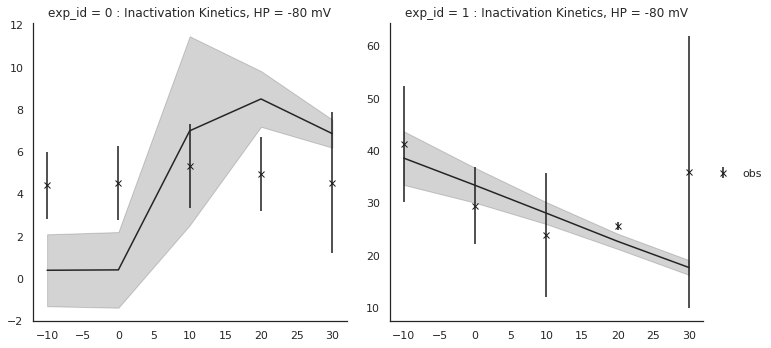

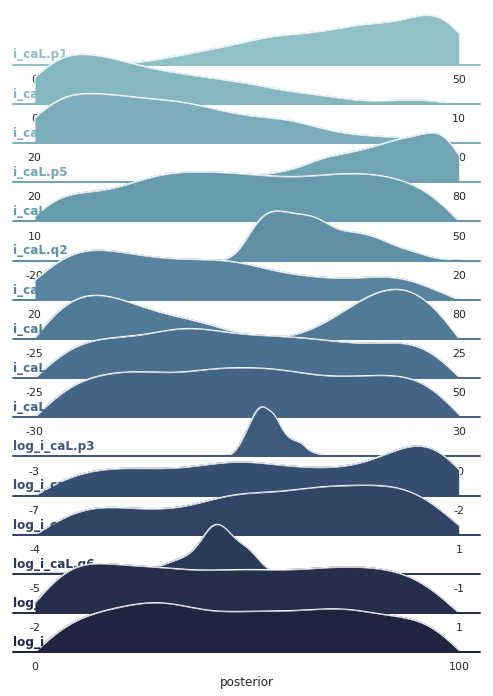

In [16]:
history = History(db_path)
history.id = 6 #(3 corresponds to the inactivation kinetics )
# 4 corresponds to the inactivation kinetics corrected in mS
# 6 corresponds to the inactivation kinetics corrected in mS eps = 1.126
df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,Li_inact_kin_80,df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [32]:
#grid2.savefig('results/ina_nygren_posterior_recovery_saka_pop_10000.pdf')
#grid1.savefig('results/ina_nygren_experiments_recovery_saka__pop_10000.pdf')